In [2]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import os, sys

import plotly.express as px
import plotly
import nbformat

%matplotlib inline

## Functions and Data

In [3]:
# multiply population
# output [0,1]
def sigmoidFunction(z, sigmoid_b, slow_scale):
    fz = []
    for num in z:
        fz.append(1/(1 + math.exp(-(num * slow_scale) + sigmoid_b)))
    return fz

def reach_climax_time (df, col_name):
    return (df[col_name].idxmax(axis=0))

def climax_value(df, col_name):
    climax_id = df[col_name].idxmax(axis=0)
    return (df[col_name].loc[climax_id])

In [4]:
# get the total number of serving population of each clinic

df_com = pd.read_excel("community.xlsx")[["社区名称","常住人口","发热诊室", "x", "y"]]#["地址"]
df_com.fillna(10000, inplace = True)

clinic_name_list = ["金洲社区卫生服务站", "丽景社区卫生服务站", "中天社区卫生服务站", "水都社区卫生服务站"]
clinic_serve_pop_list = [0,0,0,0]
clinic_name_servepop_dic = dict(zip(clinic_name_list, clinic_serve_pop_list))
for i in range(0, len(df_com)):
    clinic_name_servepop_dic[(df_com.iloc[i]["发热诊室"])] += df_com.iloc[i]["常住人口"]


## Simulation

In [5]:
def simulationFunc (com_population_list = [43750, 70081, 56015, 68615], clinic_name_list = \
    ["金洲社区卫生服务站", "丽景社区卫生服务站", "中天社区卫生服务站", "水都社区卫生服务站"], \
    clinic_scale_list = [15, 16, 17, 18], recover_time = 7, severe_percent = 0.1, sigmoid_b = 4.6, \
    slow_scale = 0.25, max_sim = 100):

    date_list = list(range(0,max_sim,1))

    total_severe_day_list = [[],[],[],[]]
    clinic_avai_day_list = [[],[],[],[]]
    total_severe_pop = [0,0,0,0]
    total_severe_day_arr = np.zeros((4, len(date_list)))

    #current_clinic_avai = clinic_scale_list #updated everyday

    for day in date_list:
        for i in range(4):
            infected_day_arr = np.asarray(
                sigmoidFunction(date_list, sigmoid_b,
                            slow_scale)) * np.array(com_population_list[i])
            new_infected_list = np.diff(np.insert(infected_day_arr, 0, 0))

            # severe cases
            new_infected_arr = np.asarray(new_infected_list)
            new_severe_arr = new_infected_arr * severe_percent

            total_severe_pop[i] = total_severe_pop[i] + new_severe_arr[day] - clinic_scale_list[i]
            #print(total_severe_pop[i])
            total_severe_day_list[i].append(total_severe_pop[i])
            #print(total_severe_day_list[i])

            if total_severe_pop[i] > 0:
                avai_to_append = 0
            else:
                avai_to_append = total_severe_pop[i] * (-1)
            clinic_avai_day_list[i].append(avai_to_append) ###
            
            total_severe_day_arr[i, day] = np.clip(np.asarray(total_severe_day_list[i][day]),0,com_population_list[i])
            total_severe_day_list[i][day] = np.clip(np.asarray(total_severe_day_list[i][day]),0,com_population_list[i])
            #print(total_severe_day_list[i][day])
            #print("")
            #total_severe_day_list = total_severe_day_arr.tolist() 
            total_severe_pop[i] = total_severe_day_list[i][day] 

            

    df_severe_byday = pd.DataFrame()
    for i in range(4):
        df_severe_byday[clinic_name_list[i]] = total_severe_day_arr[i]

    return df_severe_byday

    

In [6]:
df_severe_byday = simulationFunc (max_sim = 200)


## Plotly

In [6]:
df_severe_byday = simulationFunc (max_sim = 200)
df_severe_byday.head()

,金洲社区卫生服务站,丽景社区卫生服务站,中天社区卫生服务站,水都社区卫生服务站
0,28.539133,53.743223,38.745018,50.284289
1,25.747779,57.299659,37.376271,51.431631
2,26.323435,66.249546,40.318450,57.859599
3,31.159007,82.023186,48.714784,70.968578
4,41.361847,106.394391,63.983060,92.495271


### Transform

In [24]:
# df_T = pd.DataFrame(df_severe_byday.values.T,columns=index_row,index=index_colums)
transformed_df = pd.DataFrame({"day": [], "severe cases": [], "name": []})
clinic_name_list = ["金洲社区卫生服务站", "丽景社区卫生服务站", "中天社区卫生服务站", "水都社区卫生服务站"]

for i in range (len(df_severe_byday)):
    
    one_line = df_severe_byday.iloc[i]
    one_column_list = (df_severe_byday.iloc[i].T).tolist()
    one_day_list = (np.ones(4,int)*i).tolist()
    one_df = pd.DataFrame({"day": one_day_list, "severe cases": one_column_list, "name": clinic_name_list})
    transformed_df = pd.concat([transformed_df,one_df], ignore_index=True)

px.bar(transformed_df,x="name",y="severe cases",animation_frame = 'day', range_y = [0, 8000])

In [30]:
px.bar(transformed_df,x="name",y="severe cases",animation_frame = 'day', range_y = [0, 8000], color = "name", color_discrete_sequence=px.colors.qualitative.Antique)

## Seaborn

In [5]:
df_severe_byday = simulationFunc (max_sim = 200)
df_severe_byday.head()

,金洲社区卫生服务站,丽景社区卫生服务站,中天社区卫生服务站,水都社区卫生服务站
0,28.539133,53.743223,38.745018,50.284289
1,25.747779,57.299659,37.376271,51.431631
2,26.323435,66.249546,40.318450,57.859599
3,31.159007,82.023186,48.714784,70.968578
4,41.361847,106.394391,63.983060,92.495271


Generating pictures to the folder pic_for_video3...199/200

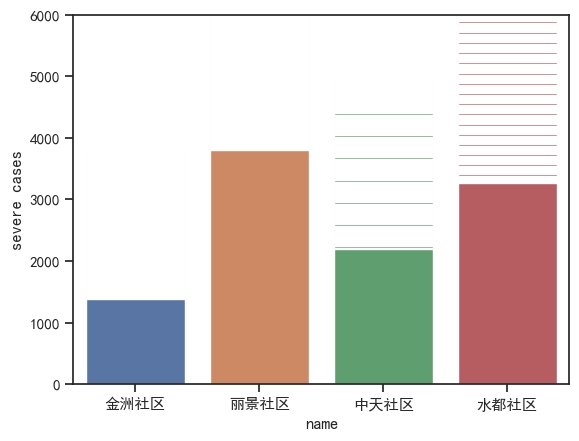

In [9]:
clinic_name_list_short = ["金洲社区", "丽景社区", "中天社区", "水都社区"]


for i in range(len(df_severe_byday)):
    #print(i)
    folder = "pic_for_video3"
    save_path = folder + '/' + str(i) + '.jpg'
    print('\r'+"Generating pictures to the folder " + folder + "..." + str(i)+'/'+str(len(df_severe_byday)), end='')
    one_df = pd.DataFrame()
    one_df["name"] = clinic_name_list_short
    one_df["severe cases"] = df_severe_byday.iloc[i].tolist()

    rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
    sns.set(context='notebook', style='ticks', rc=rc)
    bar_plot = sns.barplot(x="name", y="severe cases", data=one_df)
    bar_plot.set_ylim(0,6000)

    
    # cv.imwrite(save_path, bar_plot, [cv.IMWRITE_PNG_COMPRESSION, 0])

    fig_tosave = bar_plot.get_figure()
    fig_tosave.savefig(save_path, dpi = 400)

In [ ]:
read_path = 'pic_for_video/' + str(0) + '.png'
frame = cv.imread(read_path)
print(frame.shape)

(1920, 2560, 3)


In [10]:
fourcc = cv.VideoWriter_fourcc(*'mp4v')
save_video_folder = "video_generated"
out = cv.VideoWriter(save_video_folder + '/testwrite.mp4',fourcc, 20.0, (2560,1920),True)

for i in range(len(df_severe_byday)):
    print('\r'+"Generating a video to the folder " + save_video_folder + "..." + str(i)+'/'+str(len(df_severe_byday)), end='')
    read_path = 'pic_for_video3/' + str(i) + '.jpg'
    frame = cv.imread(read_path)
    out.write(frame)
    #print("i: ",i)

out.release()


Generating pictures to the folder video_generated...199/200

## Compute weights

In [ ]:
df_severe_byday = simulationFunc ()

reach_climax_time_list = []
climax_value_list = []
clinic_name_list = ["金洲社区卫生服务站", "丽景社区卫生服务站", "中天社区卫生服务站", "水都社区卫生服务站"]

for name in clinic_name_list:
    reach_climax_time_list.append(reach_climax_time(df_severe_byday, name))
    climax_value_list.append(climax_value(df_severe_byday, name))

clinic_name_climax_time_dic = dict(zip(clinic_name_list, reach_climax_time_list))
clinic_name_climax_value_dic = dict(zip(clinic_name_list, climax_value_list))

df_all = pd.read_excel("community.xlsx")[["社区名称","常住人口","发热诊室", "x", "y"]]
df_all["达峰时间"] = np.zeros(len(df_all))
df_all["峰值"] = np.zeros(len(df_all))

for clinic in clinic_name_list:
    df_all.loc[df_all['发热诊室']==clinic,"达峰时间"] = clinic_name_climax_time_dic[clinic]
    df_all.loc[df_all['发热诊室']==clinic,"峰值"] = clinic_name_climax_value_dic[clinic]

temp = df_all["峰值"]/df_all["达峰时间"]
df_all["w"] = temp / (temp.max())

In [ ]:
df_all.head()

,社区名称,常住人口,发热诊室,x,y,达峰时间,峰值,w
0,金山街道金洲社区,8500.0,金洲社区卫生服务站,1154,283,35.0,3767.101065,0.628755
1,金山街道幸福社区,7850.0,丽景社区卫生服务站,801,945,37.0,6333.725979,1.000000
2,金山街道六江道社区,6900.0,中天社区卫生服务站,432,980,36.0,4904.562571,0.795867
3,金山街道金环社区,10832.0,金洲社区卫生服务站,1303,256,35.0,3767.101065,0.628755
4,金山街道鑫龙社区,9000.0,丽景社区卫生服务站,704,479,37.0,6333.725979,1.000000


In [ ]:
temp

0     107.631459
1     171.181783
2     136.237849
3     107.631459
4     171.181783
5     107.631459
6     136.237849
7     171.181783
8     165.203093
9     136.237849
10    136.237849
11    136.237849
12    165.203093
13    171.181783
14    165.203093
15    171.181783
16    165.203093
17    107.631459
18    107.631459
19    165.203093
20    171.181783
dtype: float64

## Write the data into excel

In [ ]:
output_excel = pd.read_excel("community.xlsx")
output_excel["w"] = df_all["w"]
output_excel.to_excel("community.xlsx")